In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 980

nband = 120

nv = 200

dv = 0.005

tsfc =294

ng =20

nref =1

p_refs = (/ 50 /) 

t_refs = (/ 250 /) 

ng_refs = (/ 20 /) 

data wgt
     &     /1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1,
     &     1 , 1 , 1 , 1/

option_wgt_flux =2

option_wgt_k =1

option_klin =0

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66/

klin =0

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

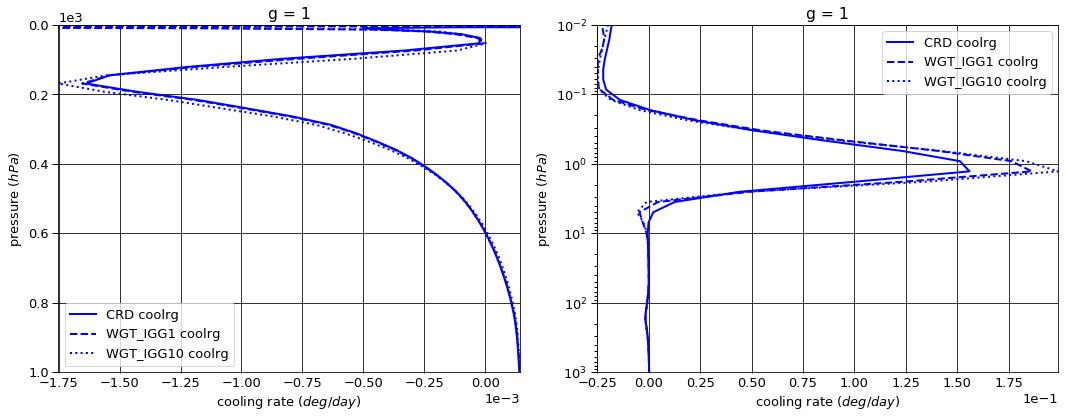

# Figure: cooling rate g-group 2

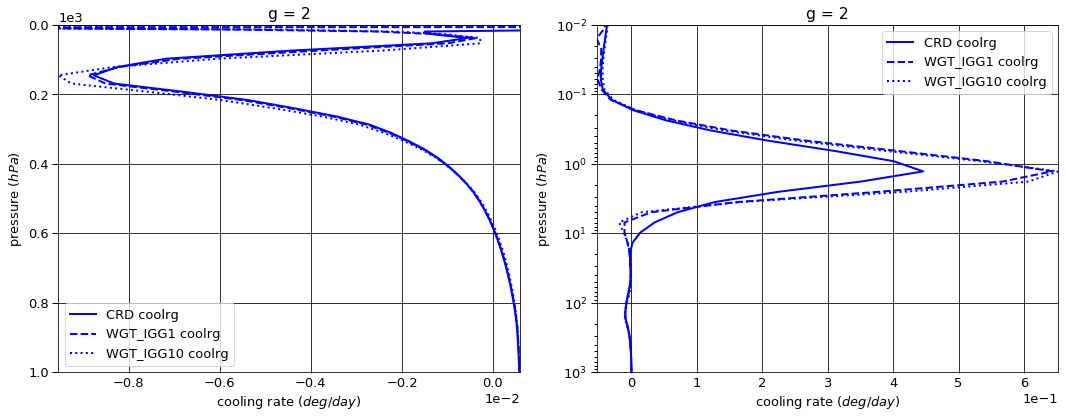

# Figure: cooling rate g-group 3

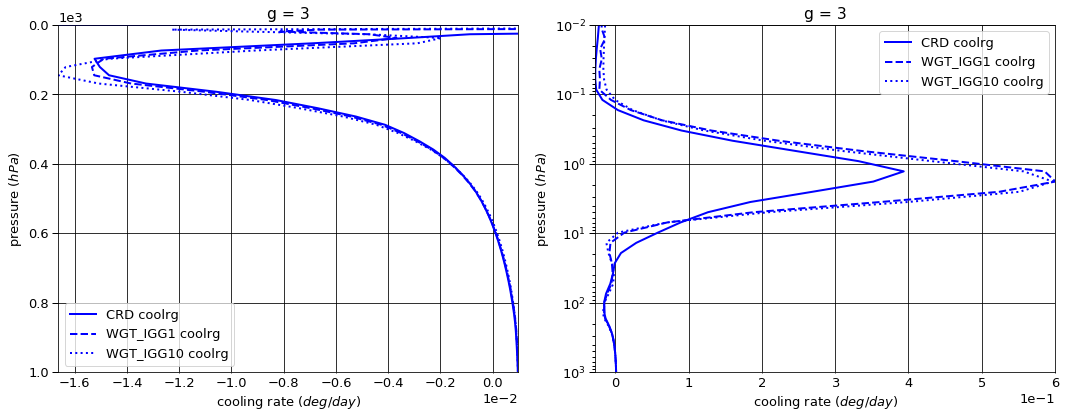

# Figure: cooling rate g-group 4

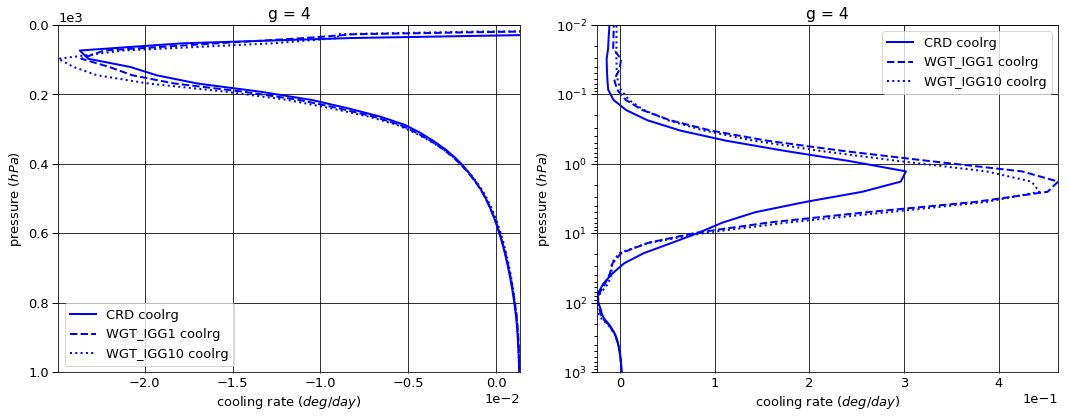

# Figure: cooling rate g-group 5

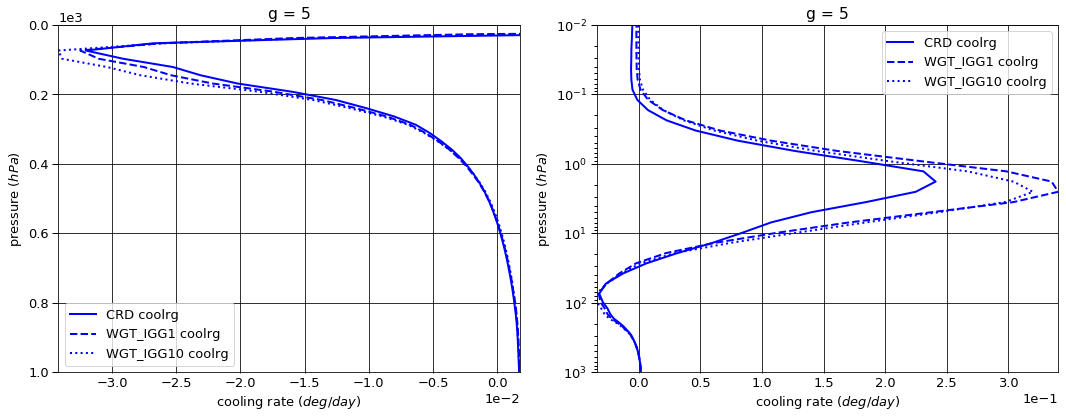

# Figure: cooling rate g-group 6

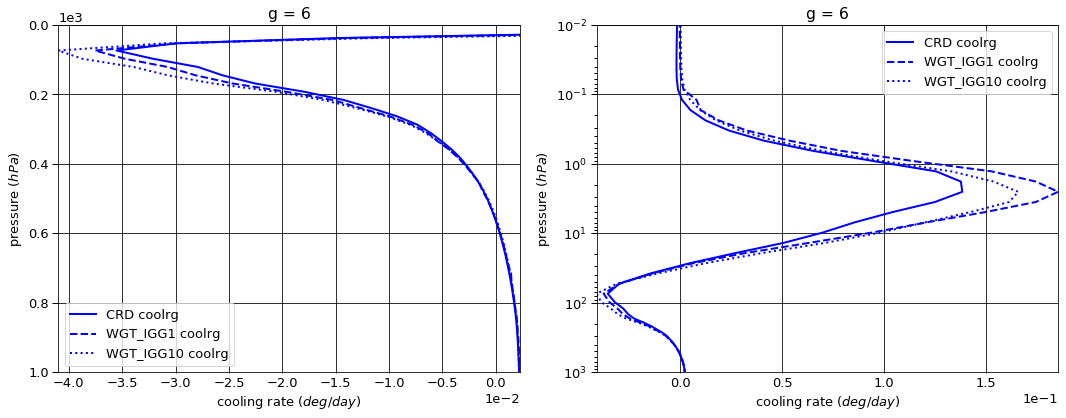

# Figure: cooling rate g-group 7

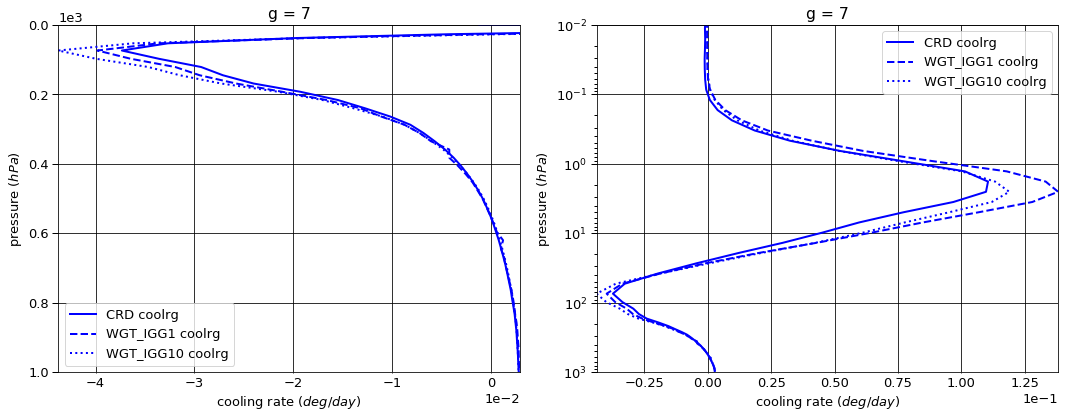

# Figure: cooling rate g-group 8

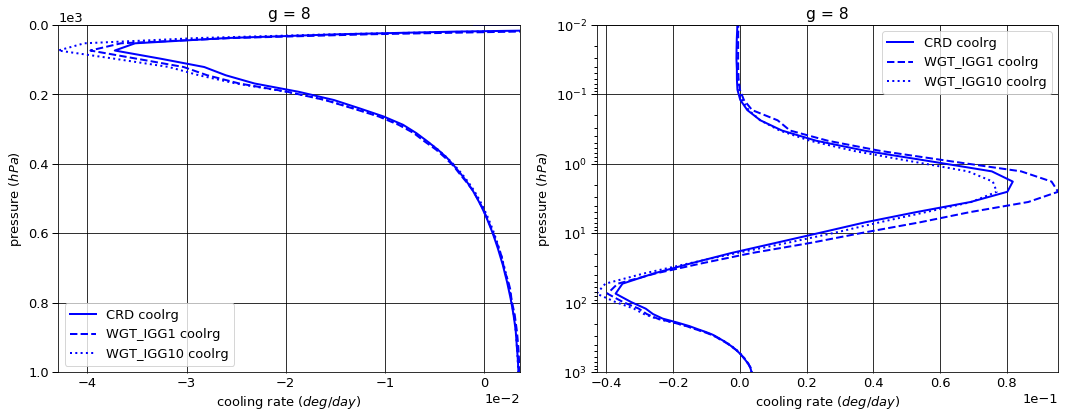

# Figure: cooling rate g-group 9

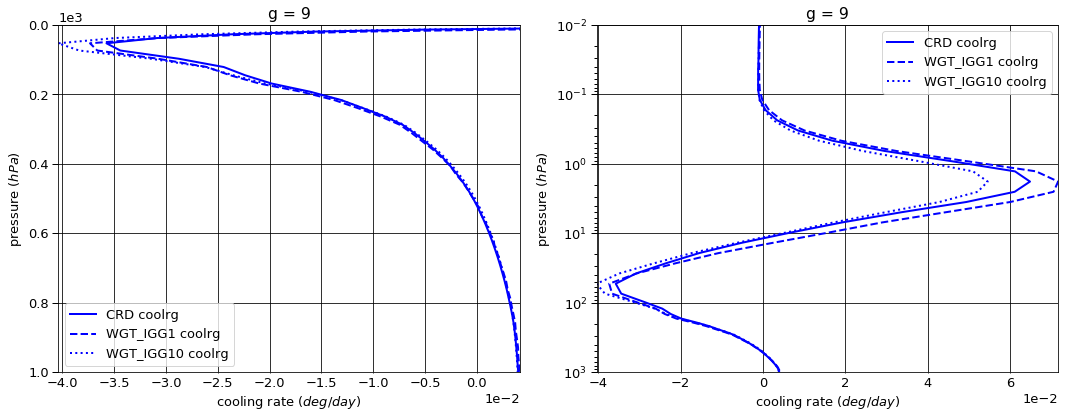

# Figure: cooling rate g-group 10

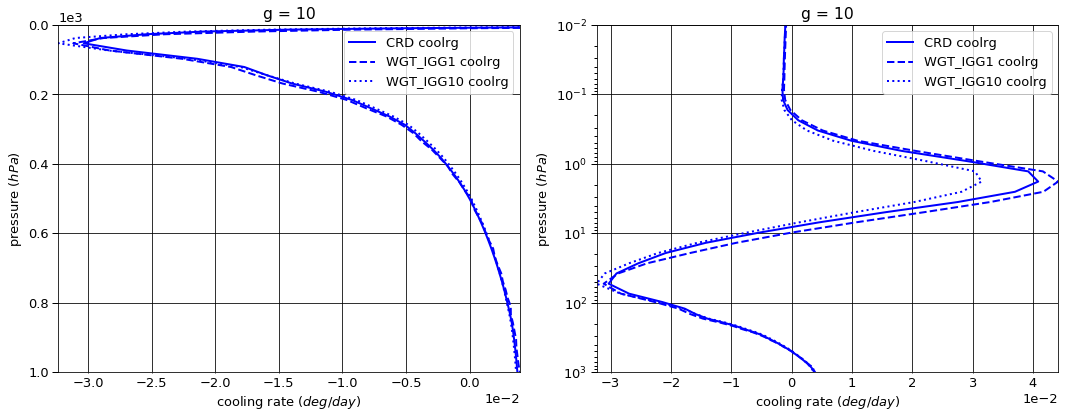

# Figure: cooling rate g-group 11

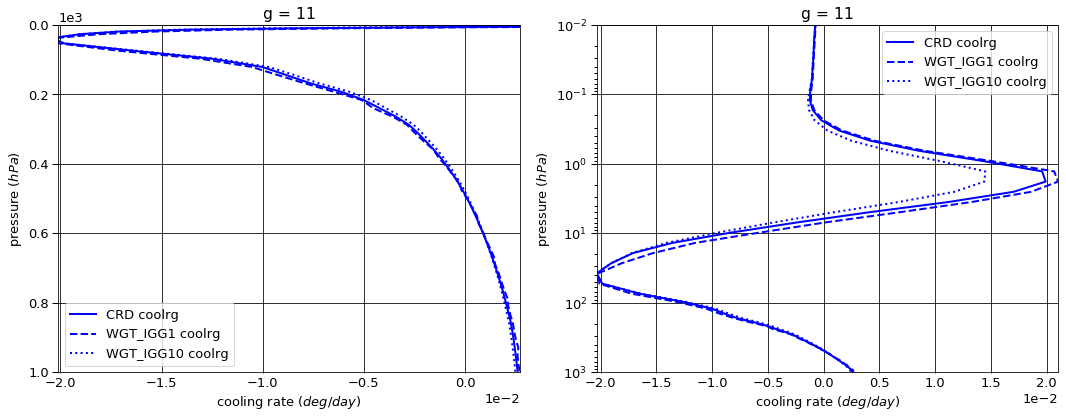

# Figure: cooling rate g-group 12

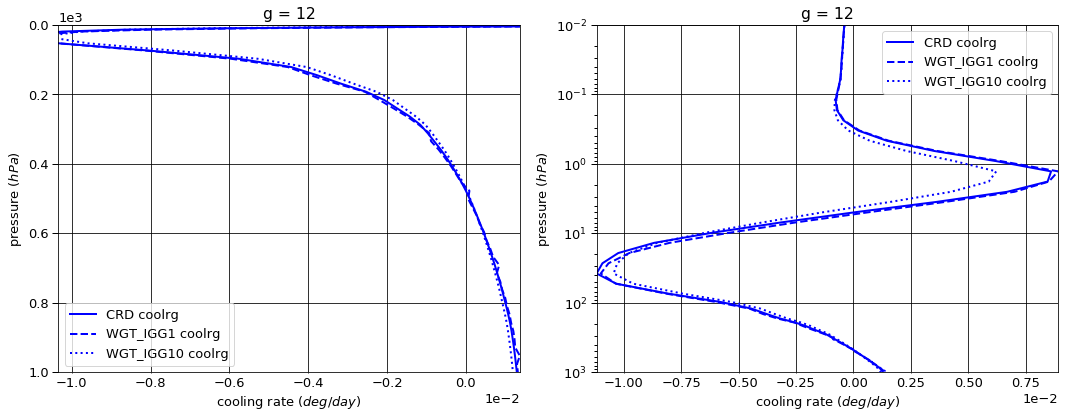

# Figure: cooling rate g-group 13

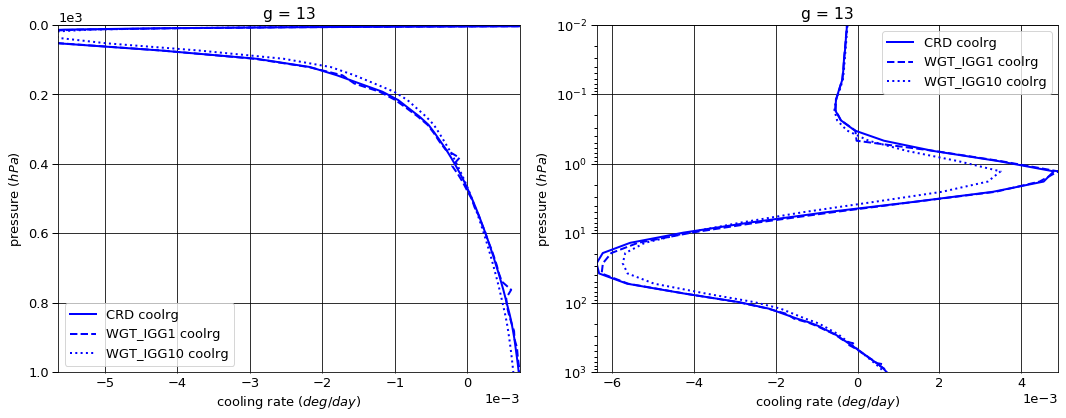

# Figure: cooling rate g-group 14

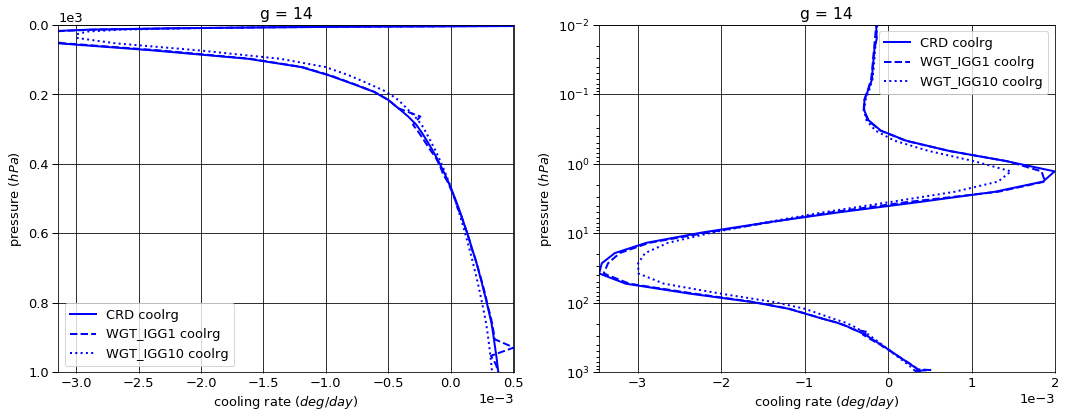

# Figure: cooling rate g-group 15

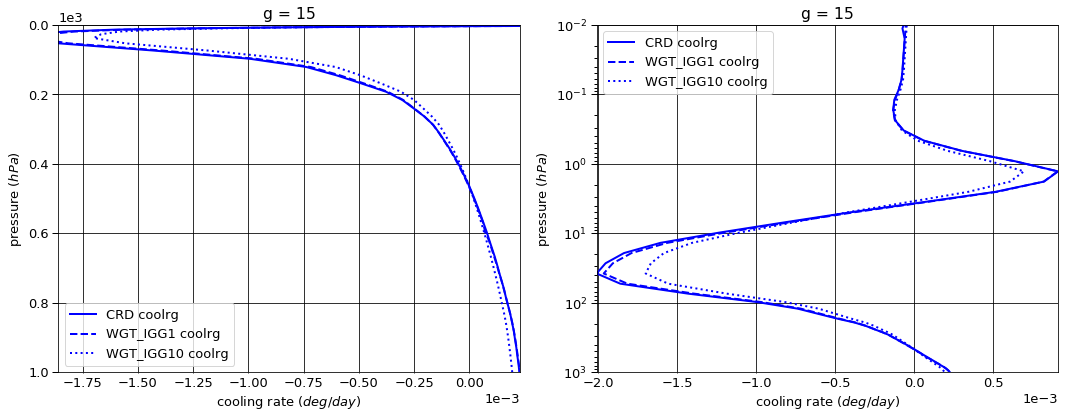

# Figure: cooling rate g-group 16

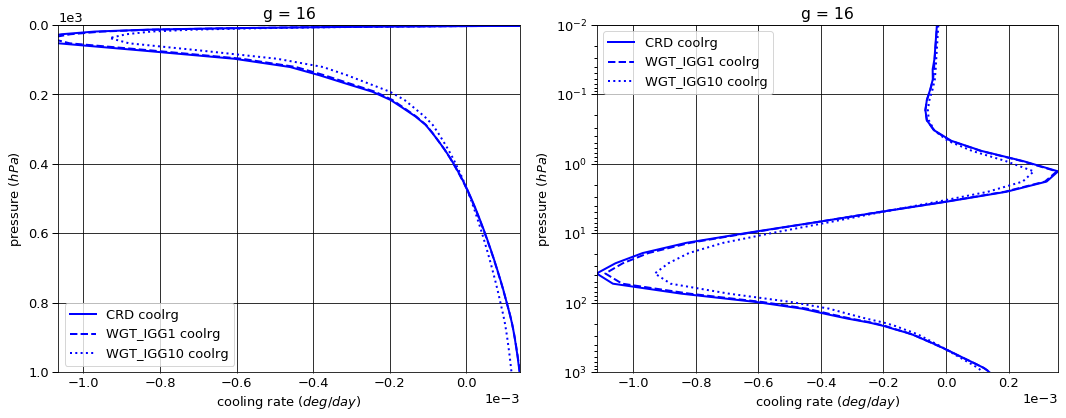

# Figure: cooling rate g-group 17

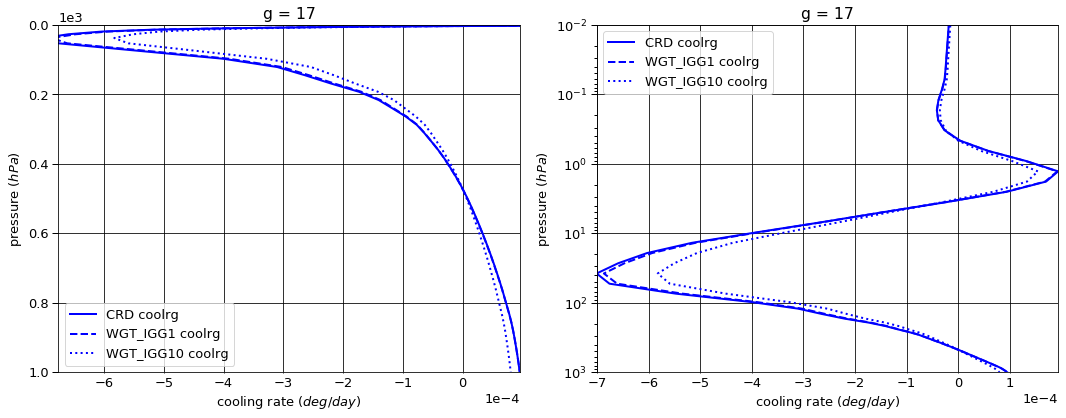

# Figure: cooling rate g-group 18

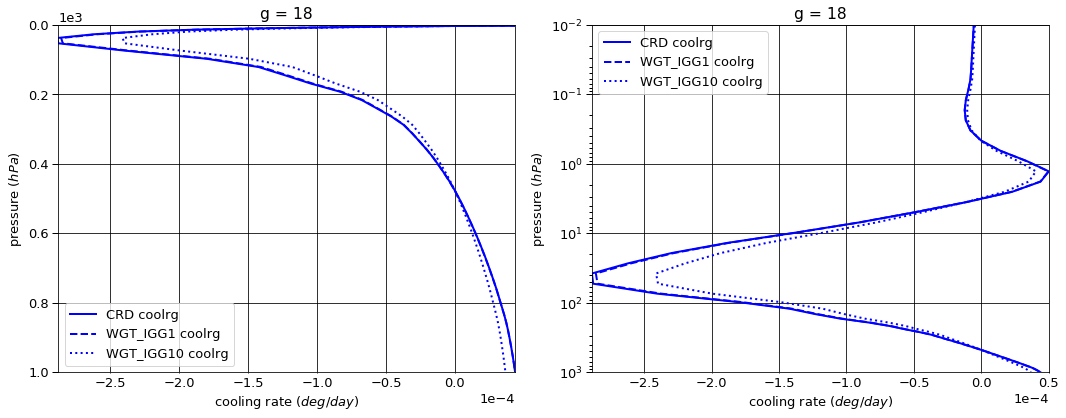

# Figure: cooling rate g-group 19

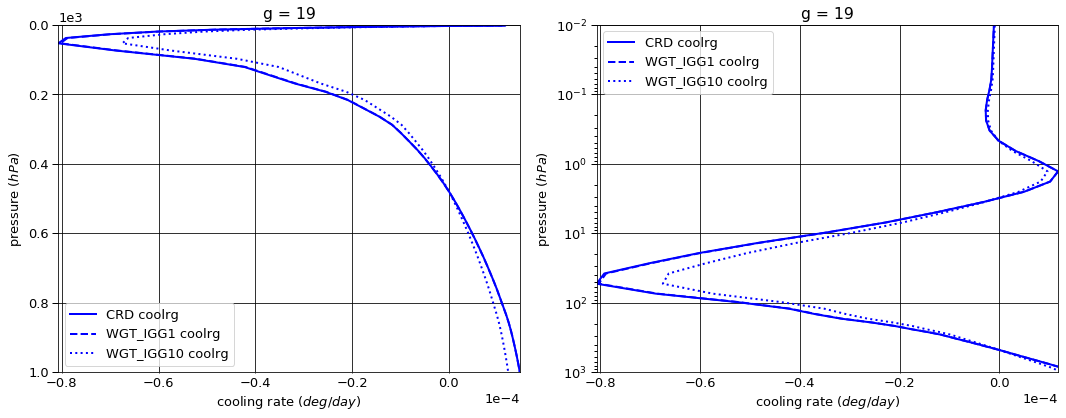

# Figure: cooling rate g-group 20

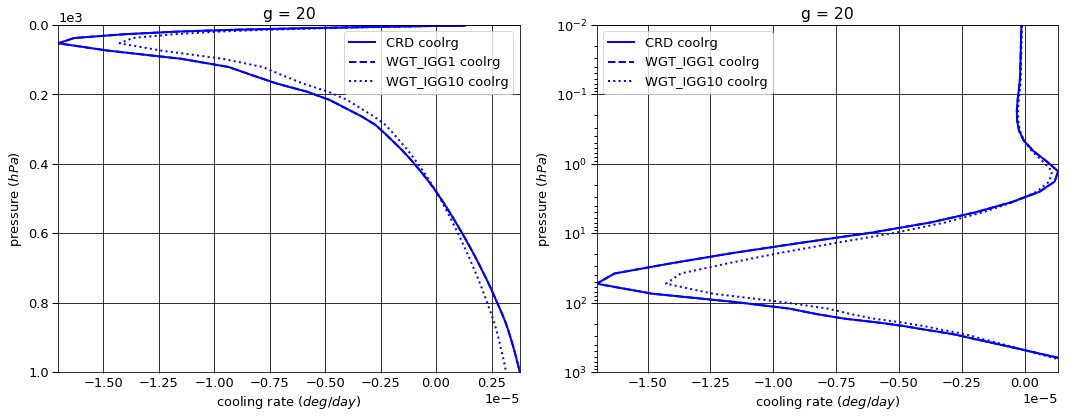

# Figure: cooling rate g-group total

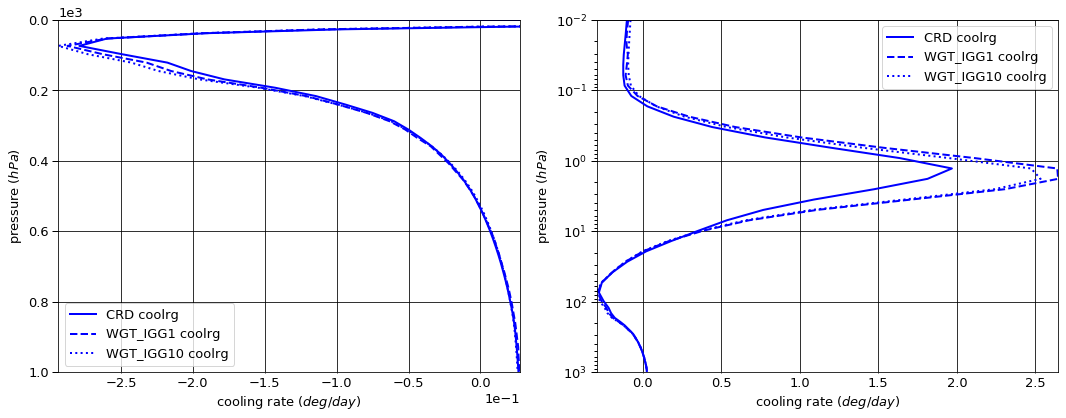

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.031556  0.000000 -0.031556
   1013.0   76    -0.059184  0.027081 -0.032103
2  0.0      1     -0.140932  0.000000 -0.140932
   1013.0   76    -0.295266  0.118461 -0.176804
3  0.0      1     -0.204580  0.000000 -0.204580
   1013.0   76    -0.513650  0.194973 -0.318677
4  0.0      1     -0.250772  0.000000 -0.250772
   1013.0   76    -0.744813  0.268204 -0.476609
5  0.0      1     -0.305280  0.000000 -0.305280
   1013.0   76    -1.011813  0.352094 -0.659718
6  0.0      1     -0.397204  0.000000 -0.397204
   1013.0   76    -1.317721  0.439177 -0.878544
7  0.0      1     -0.625033  0.000000 -0.625033
   1013.0   76    -1.743234  0.537478 -1.205756
8  0.0      1     -1.033679  0.000000 -1.033679
   1013.0   76    -2.255118  0.608104 -1.647014
9  0.0      1     -1.657039  0.000000 -1.657039
   1013.0   76    -2.845364  0.623692 -2.221672
10 0.0      1     -2.242937  0.000000 -2.242937
   1013.0   76    -3.192855  0.523121 -2.669735
11 0.0      1     -2.451258  0.000000 -2.451258
   1013.0   76    -3.032836  0.331424 -2.701412
12 0.0      1     -2.227769  0.000000 -2.227769
   1013.0   76    -2.505497  0.159204 -2.346293
13 0.0      1     -2.151176  0.000000 -2.151176
   1013.0   76    -2.296437  0.084098 -2.212339
14 0.0      1     -2.002115  0.000000 -2.002115
   1013.0   76    -2.079565  0.043958 -2.035607
15 0.0      1     -1.965613  0.000000 -1.965613
   1013.0   76    -2.011083  0.025420 -1.985663
16 0.0      1     -1.795994  0.000000 -1.795994
   1013.0   76    -1.822808  0.015034 -1.807774
17 0.0      1     -1.768287  0.000000 -1.768287
   1013.0   76    -1.786033  0.010043 -1.775989
18 0.0      1     -1.144102  0.000000 -1.144102
   1013.0   76    -1.151920  0.004466 -1.147455
19 0.0      1     -0.512686  0.000000 -0.512686
   1013.0   76    -0.514991  0.001397 -0.513595
20 0.0      1     -0.173539  0.000000 -0.173539
   1013.0   76    -0.174048  0.000330 -0.173719


WGT_IGG1


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.033277  0.000000 -0.033277
   1013.0   76    -0.059184  0.027260 -0.031924
2  0.0      1     -0.161424  0.000000 -0.161424
   1013.0   76    -0.295266  0.119442 -0.175823
3  0.0      1     -0.243733  0.000000 -0.243733
   1013.0   76    -0.513650  0.197118 -0.316532
4  0.0      1     -0.291138  0.000000 -0.291138
   1013.0   76    -0.744813  0.271775 -0.473038
5  0.0      1     -0.333012  0.000000 -0.333012
   1013.0   76    -1.011813  0.358384 -0.653428
6  0.0      1     -0.399272  0.000000 -0.399272
   1013.0   76    -1.317721  0.447907 -0.869814
7  0.0      1     -0.613740  0.000000 -0.613740
   1013.0   76    -1.743234  0.548978 -1.194256
8  0.0      1     -1.013067  0.000000 -1.013067
   1013.0   76    -2.255118  0.621951 -1.633167
9  0.0      1     -1.634380  0.000000 -1.634380
   1013.0   76    -2.845364  0.637933 -2.207431
10 0.0      1     -2.228556  0.000000 -2.228556
   1013.0   76    -3.192855  0.534193 -2.658663
11 0.0      1     -2.442536  0.000000 -2.442536
   1013.0   76    -3.032836  0.339148 -2.693688
12 0.0      1     -2.225093  0.000000 -2.225093
   1013.0   76    -2.505497  0.162185 -2.343311
13 0.0      1     -2.150755  0.000000 -2.150755
   1013.0   76    -2.296437  0.085156 -2.211281
14 0.0      1     -2.002444  0.000000 -2.002444
   1013.0   76    -2.079565  0.044454 -2.035111
15 0.0      1     -1.966130  0.000000 -1.966130
   1013.0   76    -2.011083  0.025473 -1.985610
16 0.0      1     -1.796380  0.000000 -1.796380
   1013.0   76    -1.822808  0.015065 -1.807743
17 0.0      1     -1.768501  0.000000 -1.768501
   1013.0   76    -1.786033  0.010051 -1.775981
18 0.0      1     -1.144151  0.000000 -1.144151
   1013.0   76    -1.151920  0.004468 -1.147453
19 0.0      1     -0.512692  0.000000 -0.512692
   1013.0   76    -0.514991  0.001397 -0.513594
20 0.0      1     -0.173539  0.000000 -0.173539
   1013.0   76    -0.174048  0.000330 -0.173718


WGT_IGG10


flug      fldg     fnetg
g  pressure level                              
1  0.0      1     -0.033914  0.000000 -0.033914
   1013.0   76    -0.059184  0.027115 -0.032069
2  0.0      1     -0.164066  0.000000 -0.164066
   1013.0   76    -0.295266  0.117723 -0.177543
3  0.0      1     -0.246009  0.000000 -0.246009
   1013.0   76    -0.513650  0.193411 -0.320239
4  0.0      1     -0.292041  0.000000 -0.292041
   1013.0   76    -0.744813  0.265220 -0.479593
5  0.0      1     -0.325358  0.000000 -0.325358
   1013.0   76    -1.011813  0.349299 -0.662513
6  0.0      1     -0.369467  0.000000 -0.369467
   1013.0   76    -1.317721  0.439607 -0.878113
7  0.0      1     -0.562526  0.000000 -0.562526
   1013.0   76    -1.743234  0.542015 -1.201219
8  0.0      1     -0.963808  0.000000 -0.963808
   1013.0   76    -2.255118  0.611760 -1.643358
9  0.0      1     -1.614928  0.000000 -1.614928
   1013.0   76    -2.845364  0.618663 -2.226701
10 0.0      1     -2.246339  0.000000 -2.246339
   1013.0   76    -3.192855  0.506035 -2.686820
11 0.0      1     -2.476024  0.000000 -2.476024
   1013.0   76    -3.032836  0.312109 -2.720727
12 0.0      1     -2.251157  0.000000 -2.251157
   1013.0   76    -2.505497  0.144790 -2.360707
13 0.0      1     -2.168083  0.000000 -2.168083
   1013.0   76    -2.296437  0.074355 -2.222083
14 0.0      1     -2.012951  0.000000 -2.012951
   1013.0   76    -2.079565  0.038027 -2.041538
15 0.0      1     -1.972734  0.000000 -1.972734
   1013.0   76    -2.011083  0.021674 -1.989409
16 0.0      1     -1.800461  0.000000 -1.800461
   1013.0   76    -1.822808  0.012711 -1.810097
17 0.0      1     -1.771276  0.000000 -1.771276
   1013.0   76    -1.786033  0.008448 -1.777585
18 0.0      1     -1.145400  0.000000 -1.145400
   1013.0   76    -1.151920  0.003745 -1.148175
19 0.0      1     -0.513065  0.000000 -0.513065
   1013.0   76    -0.514991  0.001169 -0.513822
20 0.0      1     -0.173622  0.000000 -0.173622
   1013.0   76    -0.174048  0.000276 -0.173773


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1     -1.721166e-03  0.000000e+00 -1.721166e-03
   1013.0   76    -6.938894e-18  1.793720e-04  1.793710e-04
2  0.0      1     -2.049158e-02  0.000000e+00 -2.049158e-02
   1013.0   76     0.000000e+00  9.808700e-04  9.808600e-04
3  0.0      1     -3.915348e-02  0.000000e+00 -3.915348e-02
   1013.0   76     0.000000e+00  2.144330e-03  2.144330e-03
4  0.0      1     -4.036605e-02  0.000000e+00 -4.036605e-02
   1013.0   76     0.000000e+00  3.570390e-03  3.570390e-03
5  0.0      1     -2.773223e-02  0.000000e+00 -2.773223e-02
   1013.0   76     0.000000e+00  6.290280e-03  6.290290e-03
6  0.0      1     -2.068040e-03  0.000000e+00 -2.068040e-03
   1013.0   76    -2.220446e-16  8.730480e-03  8.730480e-03
7  0.0      1      1.129244e-02  0.000000e+00  1.129244e-02
   1013.0   76     0.000000e+00  1.149965e-02  1.149970e-02
8  0.0      1      2.061260e-02  0.000000e+00  2.061260e-02
   1013.0   76     0.000000e+00  1.384643e-02  1.384640e-02
9  0.0      1      2.265900e-02  0.000000e+00  2.265900e-02
   1013.0   76     0.000000e+00  1.424129e-02  1.424130e-02
10 0.0      1      1.438000e-02  0.000000e+00  1.438000e-02
   1013.0   76     0.000000e+00  1.107209e-02  1.107210e-02
11 0.0      1      8.722300e-03  0.000000e+00  8.722300e-03
   1013.0   76     0.000000e+00  7.723840e-03  7.723800e-03
12 0.0      1      2.676600e-03  0.000000e+00  2.676600e-03
   1013.0   76     0.000000e+00  2.981490e-03  2.981500e-03
13 0.0      1      4.204000e-04  0.000000e+00  4.204000e-04
   1013.0   76     0.000000e+00  1.057831e-03  1.057800e-03
14 0.0      1     -3.297000e-04  0.000000e+00 -3.297000e-04
   1013.0   76     0.000000e+00  4.960160e-04  4.961000e-04
15 0.0      1     -5.169000e-04  0.000000e+00 -5.169000e-04
   1013.0   76    -4.440892e-16  5.339300e-05  5.340000e-05
16 0.0      1     -3.853000e-04  0.000000e+00 -3.853000e-04
   1013.0   76     2.220446e-16  3.105900e-05  3.110000e-05
17 0.0      1     -2.135000e-04  0.000000e+00 -2.135000e-04
   1013.0   76     0.000000e+00  8.104000e-06  8.100000e-06
18 0.0      1     -4.890000e-05  0.000000e+00 -4.890000e-05
   1013.0   76     0.000000e+00  1.562100e-06  1.600000e-06
19 0.0      1     -5.830000e-06  0.000000e+00 -5.830000e-06
   1013.0   76     0.000000e+00  2.251000e-07  2.300000e-07
20 0.0      1     -2.000000e-08  0.000000e+00 -2.000000e-08
   1013.0   76     0.000000e+00  1.820000e-08  2.000000e-08


WGT_IGG10 - CRD


flug      fldg     fnetg
g  pressure level                                  
1  0.0      1     -2.358006e-03  0.000000 -0.002358
   1013.0   76    -6.938894e-18  0.000034  0.000034
2  0.0      1     -2.313345e-02  0.000000 -0.023133
   1013.0   76     0.000000e+00 -0.000739 -0.000739
3  0.0      1     -4.142879e-02  0.000000 -0.041429
   1013.0   76     0.000000e+00 -0.001562 -0.001562
4  0.0      1     -4.126904e-02  0.000000 -0.041269
   1013.0   76     0.000000e+00 -0.002984 -0.002984
5  0.0      1     -2.007811e-02  0.000000 -0.020078
   1013.0   76     0.000000e+00 -0.002795 -0.002795
6  0.0      1      2.773771e-02  0.000000  0.027738
   1013.0   76    -2.220446e-16  0.000431  0.000431
7  0.0      1      6.250703e-02  0.000000  0.062507
   1013.0   76     0.000000e+00  0.004537  0.004537
8  0.0      1      6.987139e-02  0.000000  0.069871
   1013.0   76     0.000000e+00  0.003656  0.003656
9  0.0      1      4.211080e-02  0.000000  0.042111
   1013.0   76     0.000000e+00 -0.005029 -0.005029
10 0.0      1     -3.402200e-03  0.000000 -0.003402
   1013.0   76     0.000000e+00 -0.017085 -0.017085
11 0.0      1     -2.476520e-02  0.000000 -0.024765
   1013.0   76     0.000000e+00 -0.019315 -0.019315
12 0.0      1     -2.338760e-02  0.000000 -0.023388
   1013.0   76     0.000000e+00 -0.014414 -0.014414
13 0.0      1     -1.690700e-02  0.000000 -0.016907
   1013.0   76     0.000000e+00 -0.009744 -0.009744
14 0.0      1     -1.083650e-02  0.000000 -0.010837
   1013.0   76     0.000000e+00 -0.005931 -0.005931
15 0.0      1     -7.120700e-03  0.000000 -0.007121
   1013.0   76    -4.440892e-16 -0.003746 -0.003746
16 0.0      1     -4.466400e-03  0.000000 -0.004466
   1013.0   76     2.220446e-16 -0.002323 -0.002323
17 0.0      1     -2.988600e-03  0.000000 -0.002989
   1013.0   76     0.000000e+00 -0.001596 -0.001596
18 0.0      1     -1.298000e-03  0.000000 -0.001298
   1013.0   76     0.000000e+00 -0.000721 -0.000721
19 0.0      1     -3.795300e-04  0.000000 -0.000380
   1013.0   76     0.000000e+00 -0.000228 -0.000228
20 0.0      1     -8.342000e-05  0.000000 -0.000083
   1013.0   76     0.000000e+00 -0.000054 -0.000054

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1     -6.997072e-03
   1001.112500 75     1.403998e-04
2  0.000312    1     -1.443915e-02
   1001.112500 75     5.809742e-04
3  0.000312    1     -1.521299e-02
   1001.112500 75     9.630426e-04
4  0.000312    1     -4.318726e-03
   1001.112500 75     1.306088e-03
5  0.000312    1     -2.013047e-03
   1001.112500 75     1.702018e-03
6  0.000312    1     -6.453742e-04
   1001.112500 75     2.179193e-03
7  0.000312    1     -4.046968e-04
   1001.112500 75     2.825931e-03
8  0.000312    1     -3.223834e-04
   1001.112500 75     3.488658e-03
9  0.000312    1     -3.294905e-04
   1001.112500 75     4.002045e-03
10 0.000312    1     -3.645186e-04
   1001.112500 75     3.743914e-03
11 0.000312    1     -2.636393e-04
   1001.112500 75     2.603535e-03
12 0.000312    1     -1.345334e-04
   1001.112500 75     1.297758e-03
13 0.000312    1     -8.742175e-05
   1001.112500 75     7.090345e-04
14 0.000312    1     -4.879445e-05
   1001.112500 75     3.825290e-04
15 0.000312    1     -1.802118e-05
   1001.112500 75     2.260837e-04
16 0.000312    1     -9.844433e-06
   1001.112500 75     1.391760e-04
17 0.000312    1     -6.120378e-06
   1001.112500 75     9.542506e-05
18 0.000312    1     -1.927323e-06
   1001.112500 75     4.381542e-05
19 0.000312    1     -3.650358e-07
   1001.112500 75     1.472385e-05
20 0.000312    1     -4.301583e-08
   1001.112500 75     3.775673e-06


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1     -7.835799e-03
   1001.112500 75     1.418146e-04
2  0.000312    1     -1.558649e-02
   1001.112500 75     5.918316e-04
3  0.000312    1     -7.359503e-03
   1001.112500 75     9.863501e-04
4  0.000312    1     -2.873780e-03
   1001.112500 75     1.338475e-03
5  0.000312    1     -9.606442e-04
   1001.112500 75     1.759409e-03
6  0.000312    1     -2.142517e-04
   1001.112500 75     2.245164e-03
7  0.000312    1     -1.735917e-04
   1001.112500 75     2.935987e-03
8  0.000312    1     -2.130500e-04
   1001.112500 75     3.630066e-03
9  0.000312    1     -2.728187e-04
   1001.112500 75     4.155028e-03
10 0.000312    1     -3.245331e-04
   1001.112500 75     3.934488e-03
11 0.000312    1     -2.499559e-04
   1001.112500 75     2.712246e-03
12 0.000312    1     -1.331573e-04
   1001.112500 75     1.323428e-03
13 0.000312    1     -8.773895e-05
   1001.112500 75     7.243788e-04
14 0.000312    1     -4.816352e-05
   1001.112500 75     3.843743e-04
15 0.000312    1     -1.769540e-05
   1001.112500 75     2.281118e-04
16 0.000312    1     -9.578789e-06
   1001.112500 75     1.397849e-04
17 0.000312    1     -5.966031e-06
   1001.112500 75     9.557529e-05
18 0.000312    1     -1.908498e-06
   1001.112500 75     4.384158e-05
19 0.000312    1     -3.615384e-07
   1001.112500 75     1.472731e-05
20 0.000312    1     -4.306611e-08
   1001.112500 75     3.775926e-06


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1     -7.649828e-03
   1001.112500 75     1.423666e-04
2  0.000312    1     -1.376978e-02
   1001.112500 75     5.829227e-04
3  0.000312    1     -5.661772e-03
   1001.112500 75     9.666680e-04
4  0.000312    1     -1.814946e-03
   1001.112500 75     1.309343e-03
5  0.000312    1     -4.415789e-04
   1001.112500 75     1.710459e-03
6  0.000312    1     -5.436571e-05
   1001.112500 75     2.178305e-03
7  0.000312    1     -1.158900e-04
   1001.112500 75     2.813479e-03
8  0.000312    1     -2.121700e-04
   1001.112500 75     3.473292e-03
9  0.000312    1     -2.991864e-04
   1001.112500 75     3.948406e-03
10 0.000312    1     -3.510830e-04
   1001.112500 75     3.644240e-03
11 0.000312    1     -2.580450e-04
   1001.112500 75     2.491322e-03
12 0.000312    1     -1.303439e-04
   1001.112500 75     1.197910e-03
13 0.000312    1     -8.221618e-05
   1001.112500 75     6.345553e-04
14 0.000312    1     -4.373158e-05
   1001.112500 75     3.328515e-04
15 0.000312    1     -1.553474e-05
   1001.112500 75     1.937271e-04
16 0.000312    1     -8.223011e-06
   1001.112500 75     1.179997e-04
17 0.000312    1     -5.071469e-06
   1001.112500 75     8.036679e-05
18 0.000312    1     -1.612335e-06
   1001.112500 75     3.677205e-05
19 0.000312    1     -3.040974e-07
   1001.112500 75     1.233192e-05
20 0.000312    1     -3.611677e-08
   1001.112500 75     3.158111e-06


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -8.387267e-04
   1001.112500 75     1.414790e-06
2  0.000312    1     -1.147337e-03
   1001.112500 75     1.085744e-05
3  0.000312    1      7.853483e-03
   1001.112500 75     2.330751e-05
4  0.000312    1      1.444946e-03
   1001.112500 75     3.238700e-05
5  0.000312    1      1.052403e-03
   1001.112500 75     5.739160e-05
6  0.000312    1      4.311225e-04
   1001.112500 75     6.597100e-05
7  0.000312    1      2.311051e-04
   1001.112500 75     1.100555e-04
8  0.000312    1      1.093334e-04
   1001.112500 75     1.414084e-04
9  0.000312    1      5.667186e-05
   1001.112500 75     1.529825e-04
10 0.000312    1      3.998558e-05
   1001.112500 75     1.905745e-04
11 0.000312    1      1.368343e-05
   1001.112500 75     1.087105e-04
12 0.000312    1      1.376140e-06
   1001.112500 75     2.567020e-05
13 0.000312    1     -3.171950e-07
   1001.112500 75     1.534434e-05
14 0.000312    1      6.309320e-07
   1001.112500 75     1.845350e-06
15 0.000312    1      3.257730e-07
   1001.112500 75     2.028100e-06
16 0.000312    1      2.656443e-07
   1001.112500 75     6.088900e-07
17 0.000312    1      1.543468e-07
   1001.112500 75     1.502280e-07
18 0.000312    1      1.882580e-08
   1001.112500 75     2.615900e-08
19 0.000312    1      3.497370e-09
   1001.112500 75     3.465000e-09
20 0.000312    1     -5.028400e-11
   1001.112500 75     2.526000e-10


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -6.527557e-04
   1001.112500 75     1.966840e-06
2  0.000312    1      6.693730e-04
   1001.112500 75     1.948480e-06
3  0.000312    1      9.551215e-03
   1001.112500 75     3.625500e-06
4  0.000312    1      2.503780e-03
   1001.112500 75     3.254400e-06
5  0.000312    1      1.571468e-03
   1001.112500 75     8.441700e-06
6  0.000312    1      5.910085e-04
   1001.112500 75    -8.888000e-07
7  0.000312    1      2.888068e-04
   1001.112500 75    -1.245190e-05
8  0.000312    1      1.102133e-04
   1001.112500 75    -1.536630e-05
9  0.000312    1      3.030416e-05
   1001.112500 75    -5.363920e-05
10 0.000312    1      1.343568e-05
   1001.112500 75    -9.967380e-05
11 0.000312    1      5.594320e-06
   1001.112500 75    -1.122128e-04
12 0.000312    1      4.189460e-06
   1001.112500 75    -9.984750e-05
13 0.000312    1      5.205570e-06
   1001.112500 75    -7.447925e-05
14 0.000312    1      5.062877e-06
   1001.112500 75    -4.967749e-05
15 0.000312    1      2.486438e-06
   1001.112500 75    -3.235663e-05
16 0.000312    1      1.621422e-06
   1001.112500 75    -2.117631e-05
17 0.000312    1      1.048909e-06
   1001.112500 75    -1.505827e-05
18 0.000312    1      3.149889e-07
   1001.112500 75    -7.043371e-06
19 0.000312    1      6.093836e-08
   1001.112500 75    -2.391928e-06
20 0.000312    1      6.899058e-09
   1001.112500 75    -6.175622e-07

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.081552,0.000000,-23.081552
1013.0,76,-31.354237,4.367759,-26.986478



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.133821,0.000000,-23.133821
1013.0,76,-31.354237,4.452667,-26.901569



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.103228,0.000000,-23.103228
1013.0,76,-31.354237,4.288153,-27.066084



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.226936e-02,0.000000,-0.052269
1013.0,76,3.552714e-15,0.084909,0.084909



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-2.167562e-02,0.000000,-0.021676
1013.0,76,3.552714e-15,-0.079606,-0.079606


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.045618
1001.112500,75,0.026448



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.036369
1001.112500,75,0.027389



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.030916
1001.112500,75,0.025870



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.009249
1001.112500,75,0.000941



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.014702
1001.112500,75,-0.000578


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001917,0.001872
2,0.009417,0.009401
3,0.016417,0.016341
4,0.023708,0.023736
5,0.032208,0.032246
6,0.041875,0.042026
7,0.055333,0.055624
8,0.071292,0.072083
9,0.089542,0.091134


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,3.048696e-18
2,1.781781e-18
3,1.041345e-18
4,6.086042e-19
5,3.556930e-19
6,2.078814e-19
7,1.214943e-19
8,7.100619e-20
9,4.149889e-20


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,3.048696e-18,NaN,0.001917,0.001872,0.001917,0.001872,50.0
2,1.781781e-18,0.584441,0.009417,0.009401,0.011333,0.011273,50.0
3,1.041345e-18,0.584441,0.016417,0.016341,0.027750,0.027614,50.0
4,6.086042e-19,0.584440,0.023708,0.023736,0.051458,0.051350,50.0
5,3.556930e-19,0.584441,0.032208,0.032246,0.083667,0.083596,50.0
6,2.078814e-19,0.584440,0.041875,0.042026,0.125542,0.125622,50.0
7,1.214943e-19,0.584441,0.055333,0.055624,0.180875,0.181246,50.0
8,7.100619e-20,0.584441,0.071292,0.072083,0.252167,0.253330,50.0
9,4.149889e-20,0.584441,0.089542,0.091134,0.341708,0.344464,50.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog     ratio        taulyr
layer g  pressure                                                       
1     1  0.000312     1.268939e-17  4.432989e-18  2.862491  1.818108e-05
      2  0.000312     4.906646e-18  1.108099e-18  4.427987  7.030134e-06
      3  0.000312     1.562766e-18  3.373505e-19  4.632471  2.239097e-06
      4  0.000312     5.764446e-19  1.348841e-19  4.273627  8.259170e-07
      5  0.000312     2.229188e-19  6.556848e-20  3.399787  3.193932e-07
      6  0.000312     6.663963e-20  2.264324e-20  2.943026  9.547979e-08
      7  0.000312     3.376131e-20  1.349767e-20  2.501270  4.837246e-08
      8  0.000312     1.774494e-20  8.153081e-21  2.176470  2.542455e-08
      9  0.000312     1.076090e-20  5.614895e-21  1.916492  1.541798e-08
      10 0.000312     7.786198e-21  3.540419e-21  2.199230  1.115589e-08
      11 0.000312     4.799229e-21  2.047932e-21  2.343451  6.876228e-09
      12 0.000312     2.559397e-21  1.184538e-21  2.160671  3.667047e-09
      13 0.000312     1.645430e-21  7.345249e-22  2.240128  2.357535e-09
      14 0.000312     9.313797e-22  3.603748e-22  2.584475  1.334460e-09
      15 0.000312     3.346035e-22  1.786541e-22  1.872913  4.794124e-10
      16 0.000312     1.921029e-22  1.003220e-22  1.914864  2.752408e-10
      17 0.000312     1.190309e-22  6.576593e-23  1.809918  1.705449e-10
      18 0.000312     5.787135e-23  3.074586e-23  1.882248  8.291679e-11
      19 0.000312     2.424380e-23  1.666343e-23  1.454911  3.473598e-11
      20 0.000312     8.472533e-24  6.317300e-24  1.341164  1.213926e-11
2     1  0.000750     1.267748e-17  4.434861e-18  2.858596  8.205756e-06
      2  0.000750     4.904134e-18  1.108798e-18  4.422928  3.174301e-06
      3  0.000750     1.563177e-18  3.375915e-19  4.630380  1.011798e-06
      4  0.000750     5.768426e-19  1.350165e-19  4.272385  3.733731e-07
      5  0.000750     2.232396e-19  6.565273e-20  3.400310  1.444964e-07
      6  0.000750     6.678496e-20  2.268588e-20  2.943900  4.322792e-08
      7  0.000750     3.386257e-20  1.352272e-20  2.504123  2.191824e-08
      8  0.000750     1.780492e-20  8.170470e-21  2.179179  1.152460e-08
      9  0.000750     1.080379e-20  5.629582e-21  1.919111  6.992975e-09
      10 0.000750     7.810030e-21  3.549237e-21  2.200481  5.055201e-09
      11 0.000750     4.810829e-21  2.053365e-21  2.342900  3.113907e-09
      12 0.000750     2.566838e-21  1.187834e-21  2.160940  1.661438e-09
      13 0.000750     1.650466e-21  7.368136e-22  2.240004  1.068297e-09
      14 0.000750     9.334422e-22  3.614739e-22  2.582323  6.041895e-10
      15 0.000750     3.358497e-22  1.793174e-22  1.872935  2.173855e-10
      16 0.000750     1.925679e-22  1.006458e-22  1.913323  1.246435e-10
      17 0.000750     1.192775e-22  6.595526e-23  1.808461  7.720481e-11
      18 0.000750     5.794588e-23  3.082335e-23  1.879934  3.750665e-11
      19 0.000750     2.431001e-23  1.671111e-23  1.454721  1.573515e-11
      20 0.000750     8.487673e-24  6.334221e-24  1.339971  5.493819e-12
3     1  0.001052     1.265248e-17  4.438454e-18  2.850650  1.396925e-05
      2  0.001052     4.898835e-18  1.110096e-18  4.412984  5.408669e-06
      3  0.001052     1.564034e-18  3.380339e-19  4.626856  1.726807e-06
      4  0.001052     5.776813e-19  1.352696e-19  4.270593  6.378020e-07
      5  0.001052     2.239164e-19  6.581914e-20  3.401996  2.472199e-07
      6  0.001052     6.709065e-20  2.277063e-20  2.946368  7.407293e-08
      7  0.001052     3.407660e-20  1.357317e-20  2.510585  3.762303e-08
      8  0.001052     1.793197e-20  8.205927e-21  2.185246  1.979819e-08
      9  0.001052     1.089485e-20  5.659968e-21  1.924897  1.202871e-08
      10 0.001052     7.860679e-21  3.567510e-21  2.203408  8.678759e-09
      11 0.001052     4.835531e-21  2.064641e-21  2.342068  5.338776e-09
      12 0.001052     2.582675e-21  1.194683e-21  2.161807  2.851460e-09
      13 0.001052     1.661208e-21  7.415928e-22  2.240054  1.834094e-09
      14 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
